In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *

In [9]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [10]:
path

Path('/root/.fastai/data/ml-100k')

In [13]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [15]:
movies = pd.read_csv(path/'u.item', delimiter='|', header=None, usecols=(0, 1), names=('movie', 'title'), encoding='latin-1')
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [16]:
ratings.shape, movies.shape

((100000, 4), (1682, 2))

In [17]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [18]:
ratings.shape

(100000, 5)

In [20]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,703,Dead Man Walking (1995),2
1,269,Cape Fear (1962),4
2,89,"Princess Bride, The (1987)",5
3,110,"Unbearable Lightness of Being, The (1988)",1
4,862,Contact (1997),5
5,126,Scream (1996),4
6,602,"Beautician and the Beast, The (1997)",4
7,666,My Man Godfrey (1936),5
8,379,Gandhi (1982),3
9,77,Independence Day (ID4) (1996),2


In [22]:
dls.classes.keys()

dict_keys(['user', 'title'])

In [23]:
n_users, n_movies = len(dls.classes['user']), len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [27]:
one_hot_3 = one_hot(3, n_users).float()

In [28]:
user_factors.t() @ one_hot_3

tensor([0.3188, 0.3033, 0.1449, 0.9004, 0.5670])

In [29]:
user_factors[3]

tensor([0.3188, 0.3033, 0.1449, 0.9004, 0.5670])

In [34]:
class DotProductModel(Module):
  def __init__(self, n_users, n_movies, n_factors):
    super().__init__()
    self.user_factors = nn.Embedding(n_users, n_factors)
    self.movie_factors = nn.Embedding(n_movies, n_factors)

  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users * movies).sum(1)


In [37]:
model = DotProductModel(n_users, n_movies, n_factors)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [38]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,16.398357,16.299017,00:08
1,12.722198,13.081791,00:08
2,4.589232,4.948435,00:09
3,2.480186,2.917608,00:07
4,2.300005,2.718314,00:09


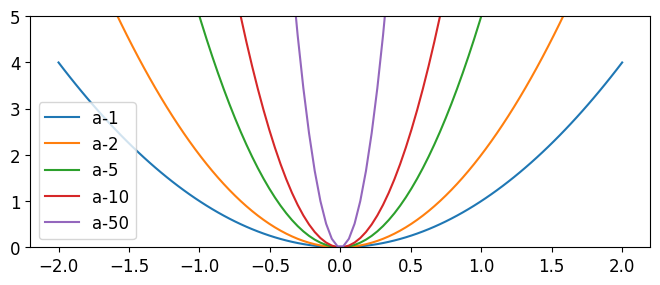

In [53]:
x = np.linspace(-2, 2, 100)
a_s = [1, 2, 5, 10, 50]
ys = [a*x**2 for a in a_s]

_,ax = plt.subplots(figsize=(8, 3))
for a, y in zip(a_s, ys):
  ax.plot(x, y, label=f'a-{a}')
ax.set_ylim([0, 5]);
ax.legend(loc='lower left');

In [54]:
model = DotProductModel(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,25.849262,27.004671,00:10
1,4.900697,6.027894,00:10
2,1.072054,1.513353,00:08
3,0.800070,1.205182,00:10
4,0.740935,1.161269,00:10


In [55]:
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [58]:
class DotProductBiasModel(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors[x[:, 0]]
    movies = self.movie_factors[x[:, 1]]
    res = (users*movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:, 1]]
    return sigmoid_range(res, *self.y_range)

In [62]:
model = DotProductBiasModel(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.919418,0.933408,00:12
1,0.666226,0.892306,00:11
2,0.540003,0.865727,00:11
3,0.443979,0.853871,00:10
4,0.418950,0.849296,00:10


In [67]:
movie_bias = model.movie_bias.squeeze()
idx = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idx]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Hellraiser: Bloodline (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Robocop 3 (1993)']

In [69]:
idx = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idx]

['Good Will Hunting (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'As Good As It Gets (1997)',
 'L.A. Confidential (1997)']

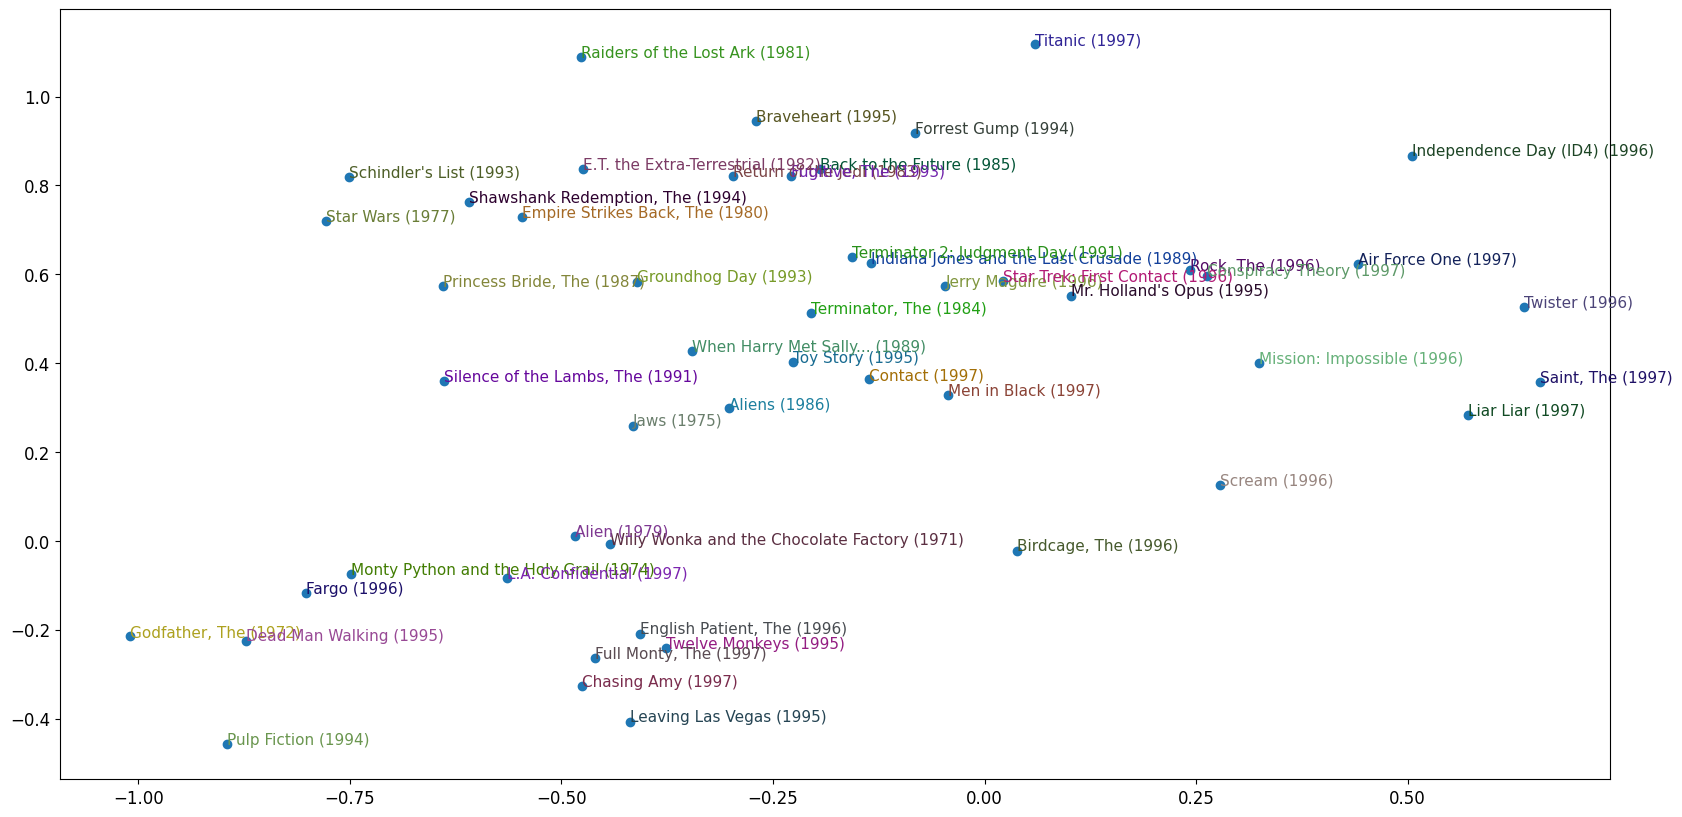

In [103]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idx = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idx].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()

idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(20, 10))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [114]:
movie_factors = learn.model.movie_factors
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1:5]
dls.classes['title'][idx]

(#4) ['Substance of Fire, The (1996)','To Kill a Mockingbird (1962)','Hamlet (1996)','Anne Frank Remembered (1995)']